In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.base import BaseTransformer
from sktime.transformations.compose import ColumnwiseTransformer

from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.compose import ColumnEnsembleTransformer

from catboost import CatBoostRegressor
import shap as sp

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
pd.options.display.max_columns = None

In [4]:
dates = pd.read_csv('m5/calendar.csv').reset_index()
dates['index'] = 'd_' + (dates['index'].astype(int)+1).astype(str)
dates =  dates.set_index('index')['date'].to_frame('ds')

In [5]:
df = pd.read_csv('m5/sales_train_evaluation.csv')

In [6]:
df['MCC'] = df['item_id'] + df['store_id']
df = df.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis=1)

In [7]:
df = df.set_index('MCC')
df['sum'] = df.sum(axis=1)
df = df.sort_values('sum', ascending=False)
df = df.iloc[:200].drop('sum', axis=1).reset_index()
df = pd.melt(df, id_vars=['MCC'], var_name='day', value_name='y').set_index('day')

In [8]:
df = df.merge(dates, left_index=True, right_index=True, how='left').set_index('ds')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# START

In [9]:
targets = ['y']
groups = ['MCC']

In [10]:
y_train, y_test = df[df.index < (df.index.max() - pd.DateOffset(months=6))], df[df.index >= (df.index.max() - pd.DateOffset(months=6))] 
y_train = y_train.sort_values(by = ['ds'] + groups)
index_train, index_test = y_train.index, y_test.index
forecast_index = pd.date_range(index_train.max() + pd.DateOffset(days=1), index_train.max()+ pd.DateOffset(years=1)).rename('ds')
groups_list =  df.drop_duplicates(groups)[groups].values.flatten().tolist()

In [11]:
class ZScoreTransformer(BaseTransformer):
    def __init__(self, window=30, threshold=3):
        self.window = window
        self.threshold = threshold
        super(ZScoreTransformer, self).__init__()

    def transform(self, Z, X=None):
        z = Z.copy()
        z_score = (z -  z.rolling(window=self.window).mean()) / z.rolling(window=self.window).std()
        z.loc[np.abs(z_score).values > self.threshold] = np.nan
        return z
    
    def inverse_transform(self, Z, X=None):
        return Z

In [12]:
window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
        "std": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
    }
)


multi_window_summarizer = ColumnEnsembleTransformer(
    transformers = [(f'window_summarizer_{target}', window_summarizer, target) for target in targets]
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([multi_window_summarizer, fourier_featurizer])

def apply_featurizer(group):
    return featurizer.fit_transform(group)

In [13]:
def create_pipeline():
    return Pipeline(
        steps=[
#            ("z_score", ZScoreTransformer(window=30, threshold=10)),
            ("imputer", Imputer(method="drift")),
#             ("boxcox", BoxCoxTransformer()),
            ("detrender", Detrender()),
            ("scale", TabularToSeriesAdaptor(StandardScaler())),
        ]
    )

def apply_pipeline_by_group(df, group_col, target_col):
    pipeline_dict = {}

    def transform_group(group):
        pipeline = create_pipeline()
        transformed = pipeline.fit_transform(group[[target_col]])
        pipeline_dict[group.name] = pipeline
        group[target_col] = transformed
        return group

    df_transformed = df.groupby(group_col).apply(transform_group).reset_index(group_col, drop=True).sort_values(by=['ds'] + group_col)
    
    return df_transformed, pipeline_dict

def inverse_transform(pipeline, series):
    for name, transformer in reversed(pipeline.steps):
        if hasattr(transformer, 'inverse_transform'):
            series = transformer.inverse_transform(series)
    return series

def inverse_transform_by_group(df, pipeline_dict, group_col, target_col):
    def inverse_transform_group(group):
        group[target_col] = inverse_transform(pipeline_dict[group.name], group[[target_col]])
        return group

    df_inverse_transformed = df.groupby(group_col).apply(inverse_transform_group).reset_index(group_col,drop=True).sort_values(by=['ds'] + group_col)
    
    return df_inverse_transformed

In [13]:
y_train_transform, pipeline_dict = apply_pipeline_by_group(y_train, groups, targets[0])
index_full = pd.MultiIndex.from_product([forecast_index, groups_list], names=['ds'] + groups).to_frame(index=False)
y_full_transform = y_train_transform.merge(index_full, on=['ds']+ groups, how='outer').set_index('ds')
X_full = y_full_transform.groupby(groups).apply(apply_featurizer).reset_index(groups)
y_full_transform = y_full_transform.set_index(groups, append=True).sort_index()

In [14]:
lag_features = [f"ColumnEnsembleTransformer__{j}_lag_{i}" for i in window_summarizer.lag_feature["lag"] for j in targets]
mean_features = [f"ColumnEnsembleTransformer__{j}_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"] for j in targets]
std_features = [f"ColumnEnsembleTransformer__{j}_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"] for j in targets]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]

X_full = X_full[groups + lag_features + mean_features + std_features + fourier_features].sort_values(by = ['ds'] + groups)
X_train, X_test = X_full.loc[X_full.index <= index_train.max()], X_full.loc[X_full.index > index_train.max()]

In [15]:
models = {}
for target in targets:
    model = CatBoostRegressor(loss_function="RMSE", has_time=True, cat_features = groups)
    model.fit(X_train, y_train_transform[target], verbose=False)
    models[target] = model

In [16]:
update_features = lag_features+mean_features+std_features

for idx in forecast_index:
    if idx.day == 1: print(idx)
    y_tmp = y_full_transform.reset_index(groups).loc[idx-pd.DateOffset(28+1):idx]
    b = y_tmp.groupby(groups).apply(apply_featurizer).reset_index(groups).sort_values(by = ['ds'] + groups).iloc[-len(groups_list):]
    X_test.loc[idx, groups + update_features] = b
    for target in targets:
        y_full_transform.loc[idx, target] = models[target].predict(X_test.loc[idx])

y_pred_transform = y_full_transform.reset_index(groups).loc[forecast_index.rename('ds')]
y_pred = inverse_transform_by_group(y_pred_transform, pipeline_dict, groups, 'y')

2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00


In [1]:
for target in targets:
    for grp in groups_list:
        print("Item ID:", grp)
        
        y_train_tmp = y_train.loc[y_train[groups].values==grp]
        y_test_tmp = y_test.loc[y_test[groups].values==grp]
        y_pred_tmp = y_pred.loc[y_pred[groups].values==grp].loc[y_test_tmp.index]
        
        ES3 = ExponentialSmoothing(trend='add', seasonal='add', sp=365,).fit(y_train_tmp[target])
        y_pred_tmp['y(ES)'] = ES3.predict(forecast_index)   
        
        print("MSE(ES):", mean_squared_error(y_test_tmp[target], y_pred_tmp['y(ES)'], squared=False))
        print("MSE:", mean_squared_error(y_test_tmp[target], y_pred_tmp[target], squared=False))
        #print("MAPE:", mean_absolute_percentage_error(y_test_tmp[target], y_pred_tmp[target]))
        
        plt.plot(y_train_tmp.index, y_train_tmp[target], label='train')
        plt.plot(y_test_tmp.index, y_test_tmp[target], label='test')
        plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
        plt.show()

        fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

        ax0.plot(y_test_tmp.index, y_test_tmp[target], label='test')
        ax0.plot(y_pred_tmp.index, y_pred_tmp['y(ES)'], label='predict (ES)')
        ax0.legend()
        ax1.plot(y_test_tmp.index, y_test_tmp[target], label='test')
        ax1.plot(y_pred_tmp.index, y_pred_tmp[target], label='predict (CatboosTS)')
        ax1.legend()
        plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
        plt.show()

NameError: name 'targets' is not defined

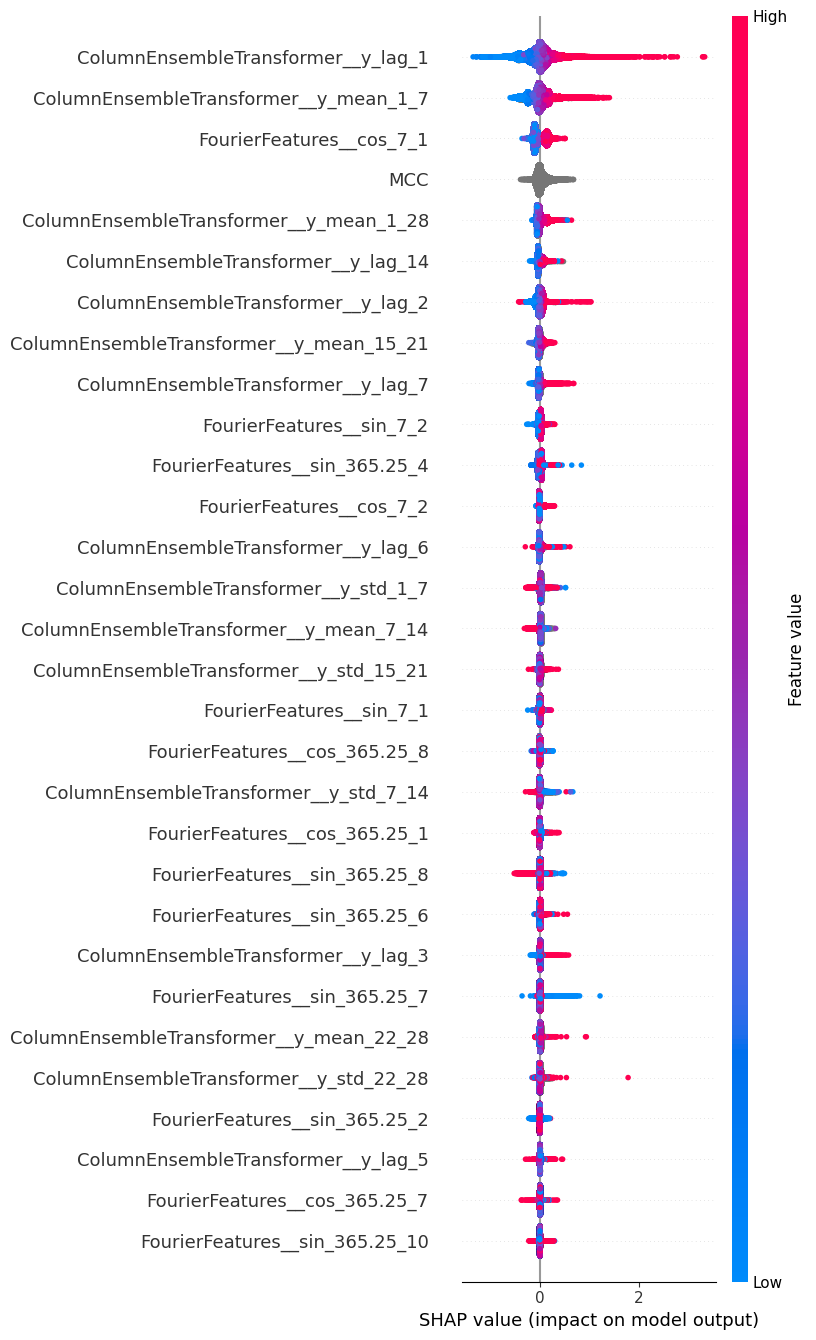

In [19]:
explainer = sp.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train, max_display=30)